# Data preprocessing

In [1]:
import deeplake
from skimage.color import rgb2gray
import numpy as np
import time
import wandb
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from itertools import chain

C:\Users\marke\anaconda3\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.1.4) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
val_ds = deeplake.load('hub://luizapzbn/CODEBRIM_classification_dataset-val')
train_ds = deeplake.load('hub://luizapzbn/CODEBRIM_classification_dataset-train')

hub://luizapzbn/CODEBRIM_classification_dataset-val loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-val
hub://luizapzbn/CODEBRIM_classification_dataset-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-train


# Loading in training data

In [9]:
# train set
X_train = train_ds.images.numpy()
y_train = train_ds.labels.data()
train_labels = list(chain.from_iterable(train_ds.labels.data()['text']))

In [11]:
print(X_train.size*X_train.itemsize*0.000001)

1274.216448


# Loading in validation data

In [3]:
X_val = val_ds.images.numpy()
y_val = val_ds.labels.data()
val_labels = list(chain.from_iterable(val_ds.labels.data()['text']))

In [8]:
print(X_val.size*X_val.itemsize*0.000001)

121.11052799999999


# Manipulating training and validation picture format for training Random Forest model

# Helper functions and image preprocessing

In [27]:
# helper functions
# for creating a log_bar and logging it to WandB
# for creating a histogram and logging it to WandB

def log_bar(x, y, title, x_name="x", y_name="y", keep_order=False):
    if keep_order:
        x = [f"{idx}: {x_}" for idx, x_ in enumerate(x)] # Make sure alphabetical sorting works
    table = wandb.Table(
        data=[[x, y] for x, y in zip(x, y)],
        columns=[x_name, y_name]
    )
    wandb.log({title: wandb.plot.bar(table, x_name, y_name, title=title)})


def create_histogram(data, min_value=None, max_value=None, bins=10):
    if min_value is None:
        min_value = data.min()
    if max_value is None:
        max_value = data.max()

    if isinstance(bins, int):
        bin_edges = np.linspace(min_value, max_value, num=bins)
    else:
        bin_edges = bins
        
    numbers, _ = np.histogram(data, bins=bin_edges)
    bin_names = [f"{lower:.1f}-{upper:.1f}" for lower, upper in zip(bin_edges[:-1], bin_edges[1:])]

    return bin_names, numbers

In [54]:
# date and time 
date_and_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# initializing connection to WandB to upload some logs about the data
wandb_run = wandb.init(
    project="inlamning1",
    name=f"preprocessing {date_and_time}"
)

# Graph for the label counts: how many pictures do we have from each category in the training and validation data

In [28]:
Counter(train_labels)

Counter({'Background': 2228,
         'Efflorescence': 348,
         'Crack': 2208,
         'Spallation': 1415,
         'CorrosionStain': 190,
         'ExposedBars': 92})

In [55]:
# labels visualizing

def label_visualizing(label_list, text):
    num_images_per_label = Counter(label_list)
    x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
    log_bar(x, num_images, f"Labels in {text} data", x_name="Label", y_name="# images")
    
label_visualizing(train_labels, 'training')
label_visualizing(val_labels, 'validation')

# Example images from training set

In [56]:
def image_displayer(pic_list):
#     pics_to_display = []
#     for pic_id in pic_list:        
    pics_to_display = [wandb.Image(X_train[id], caption=f"Training sample {id} is a type {train_labels[id]}") for id in pic_list]
    wandb.log({"Example images": pics_to_display})
    
example_pic_list = [0, 3400, 4300, 2605, 2244, 3845]
image_displayer(example_pic_list)

# Ambiguous label examples

In [57]:
def ambi_display(pic_list):
    pics_to_display = [wandb.Image(X_val[id], caption=f"Crack or Spallation? Label is: {val_labels[id]}") for id in pic_list]
    wandb.log({"Ambiguous categories": pics_to_display})
    
ambi_pic_list = [158, 423, 292, 261]
ambi_display(ambi_pic_list)

# Adding data summary to the project description

In [58]:
# RGB values
r = X_train[:,:,:,0]
g = X_train[:,:,:,1]
b = X_train[:,:,:,2]

In [59]:
# Adding a summary log to the PROJECTS description
# Log the datasets minimum and maximum intensities and datatype to the WandB summary

min_value = min(X_train.min(), X_val.min())
max_value = max(X_train.max(), X_val.max())
wandb_run.summary["raw"] = {"min": min_value, "max": max_value, "dtype": str(X_train.dtype)}

# Create a new histogram of the image pixels intensities
# Red
bin_names, train_hist = create_histogram(r)
log_bar(bin_names, train_hist, "Training data red pixels", x_name="red_value_bins", y_name="# pixels", keep_order=True)
# Green
bin_names, train_hist = create_histogram(g)
log_bar(bin_names, train_hist, "Training data green pixels", x_name="green_value_bins", y_name="# pixels", keep_order=True)
# Blue
bin_names, train_hist = create_histogram(b)
log_bar(bin_names, train_hist, "Training data blue pixels", x_name="blue_value_bins", y_name="# pixels", keep_order=True)

# Logging the average pixel intensity for the whole training image dataset

In [ ]:
# NOTE use this cell for the grayscale image preprocessing!
# greying the pictures
X_train=rgb2gray(X_train)
# resampling the values from 0-255
X_train = (X_train*255).astype('uint8')

# NOTE use this cell for the grayscale image preprocessing!
# greying the pictures
X_val=rgb2gray(X_val)
# resampling the values from 0-255
X_val = (X_val*255).astype('uint8')

# white_values 
# NOTE this line only works if we did the grayscale transformation!
bin_names, train_hist = create_histogram(X_train)
log_bar(bin_names, train_hist, "Training data white pixels", x_name="white_value_bins", y_name="# pixels", keep_order=True)

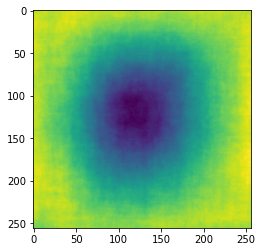

In [81]:
# Create a heatmap over all active RBG pixels from all frames
heatmap = np.mean(X_train, axis=0)
plt.imshow(heatmap)
wandb.log({"Heatmap of training images": wandb.Image(heatmap, caption="The mean of all images in the training set")})

# # Log a histogram of the average value for each pixel through out the
# # training dataset. This shows us how many of the pixels that are
# # always zero in all frames.
bin_names, heatmap_hist = create_histogram(heatmap.flatten(), bins=np.linspace(0,255,32))
log_bar(bin_names, heatmap_hist, "Average value per pixel in training data", x_name="bin", y_name="# pixels", keep_order=True)

In [82]:
# finishing wandb seccion
wandb.finish()